## Kinetic simulations

In [1]:
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import torch
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.patches import Circle
from matplotlib.ticker import FormatStrFormatter
from pathlib import Path
from pyro.ops.stats import hpdi, quantile

from tapqir.models import Cosmos
from tapqir.utils.imscroll import count_intervals, time_to_first_binding, \
    association_rate, dissociation_rate, bootstrap, posterior_estimate, \
    bound_dwell_times, unbound_dwell_times, sample_and_bootstrap

from tapqir.utils.mle_analysis import train, double_exp_model, double_exp_guide

### Load results

In [2]:
EXAMLES_DIR = Path.cwd().resolve().parent.parent.parent / "examples" / "data"

In [4]:
truth = {}
fit = {}
predictions = defaultdict(dict)
models = {}
for data_path in EXAMLES_DIR.iterdir():
    if data_path.is_dir() and data_path.name.startswith("kon"):
        truth[data_path.name] = pd.read_csv(
            data_path / "simulated_params.csv",
            squeeze=True, index_col=0
        ).rename(data_path.name)
        
        param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs64/"
        
        fit[data_path.name] = pd.read_csv(
            param_path / "global_params.csv",
            squeeze=True,
            index_col=0
        ).rename(data_path.name)
        fit[data_path.name]["height"] = truth[data_path.name]["height"]
        
        models[data_path.name] = Cosmos()
        models[data_path.name].load(data_path, True, "cpu")
        models[data_path.name].load_parameters(param_path)
        mask = torch.from_numpy(models[data_path.name].data.labels["z"])
        samples = torch.masked_select(models[data_path.name].z_marginal, mask)
        predictions[data_path.name]["z_masked"] = samples
        low, high = hpdi(samples, 0.68)
        median = quantile(samples, 0.5)
        
        z_dist = dist.Bernoulli(models[data_path.name].z_marginal)
        intervals = count_intervals(models[data_path.name].z_map)
        # calculate kon from true ttfb
        ttfb = time_to_first_binding(models[data_path.name].data.labels["z"])
        ttfb = ttfb[ttfb > 0]
        kon = 1 / ttfb.mean()
        fit[data_path.name]["kon_true"] = kon.item()
        kon_low, kon_high = bootstrap(ttfb, lambda x: 1 / x.mean())
        fit[data_path.name]["kon_true_low"] = kon_low.item()
        fit[data_path.name]["kon_true_high"] = kon_high.item()
        
        # calculate kon from ttfb
        ttfb = time_to_first_binding(models[data_path.name].z_map)
        ttfb = ttfb[ttfb > 0]
        kon = 1 / ttfb.mean()
        fit[data_path.name]["kon_ttfb"] = kon.item()
        kon_low, kon_high = sample_and_bootstrap(
            z_dist,
            lambda x: 1 / x.mean(),
            preprocess=lambda x: time_to_first_binding(x)[time_to_first_binding(x)>0]
        )
        fit[data_path.name]["kon_ttfb_low"] = kon_low.item()
        fit[data_path.name]["kon_ttfb_high"] = kon_high.item()
        
        fit[data_path.name]["koff_ttfb"] = kon.item() / fit[data_path.name]["probs_z_1"] * fit[data_path.name]["probs_z_0"]

        # calculate kon from dwell times
        dwell_time = unbound_dwell_times(intervals)
        kon = 1 / dwell_time.mean()
        fit[data_path.name]["kon"] = kon.item()
        kon_low, kon_high = sample_and_bootstrap(
            z_dist,
            lambda x: 1 / x.mean(),
            preprocess=lambda x: unbound_dwell_times(count_intervals(x))
        )
        fit[data_path.name]["kon_low"] = kon_low.item()
        fit[data_path.name]["kon_high"] = kon_high.item()
        
        # calculate koff from dwell times
        dwell_time = bound_dwell_times(intervals)
        koff = 1 / dwell_time.mean()
        fit[data_path.name]["koff"] = koff.item()
        koff_low, koff_high = sample_and_bootstrap(
            z_dist,
            lambda x: 1 / x.mean(),
            preprocess=lambda x: bound_dwell_times(count_intervals(x))
        )
        fit[data_path.name]["koff_low"] = koff_low.item()
        fit[data_path.name]["koff_high"] = koff_high.item()
       
        # calculate kon from transition probabilities matrix
        A01 = association_rate(models[data_path.name].z_map)
        A01_low, A01_high = posterior_estimate(z_dist, association_rate)
        fit[data_path.name]["A01"] = A01.item()
        fit[data_path.name]["A01_low"] = A01_low.item()
        fit[data_path.name]["A01_high"] = A01_high.item()
        
        # calculate koff from transition probabilities matrix
        A10 = dissociation_rate(models[data_path.name].z_map)
        A10_low, A10_high = posterior_estimate(z_dist, dissociation_rate)
        fit[data_path.name]["A10"] = A10.item()
        fit[data_path.name]["A10_low"] = A10_low.item()
        fit[data_path.name]["A10_high"] = A10_high.item()

KeyboardInterrupt: 

In [132]:
truth_df = pd.concat(truth.values(), axis=1).T
truth_df

,gain,kon,koff,rate_j,proximity,offset,height,background
kon3.00e-02ratej1.00e+00,7.0,0.03,0.2,1.00,0.2,90.0,3000.0,150.0
kon1.00e-02ratej1.00e+00,7.0,0.01,0.2,1.00,0.2,90.0,3000.0,150.0
kon3.00e-02ratej1.50e-01,7.0,0.03,0.2,0.15,0.2,90.0,3000.0,150.0
kon1.00e-02ratej1.00e-02,7.0,0.01,0.2,0.01,0.2,90.0,3000.0,150.0
kon2.00e-02ratej1.00e+00,7.0,0.02,0.2,1.00,0.2,90.0,3000.0,150.0
kon3.00e-02ratej5.00e-01,7.0,0.03,0.2,0.50,0.2,90.0,3000.0,150.0
kon2.00e-02ratej5.00e-01,7.0,0.02,0.2,0.50,0.2,90.0,3000.0,150.0
kon2.00e-02ratej1.00e-02,7.0,0.02,0.2,0.01,0.2,90.0,3000.0,150.0
kon3.00e-02ratej1.00e-02,7.0,0.03,0.2,0.01,0.2,90.0,3000.0,150.0
kon1.00e-02ratej1.50e-01,7.0,0.01,0.2,0.15,0.2,90.0,3000.0,150.0


In [133]:
fit_df = pd.concat(fit.values(), axis=1).T
fit_df = fit_df.drop(
    ["width_mean_0", "width_size_0", "height_scale", "height"],
    axis=1
)
fit_df

,-ELBO,proximity_0,gain,probs_z_0,probs_z_1,rate_j,MCC,Recall,Precision,FN,...,kon_high,koff,koff_low,koff_high,A01,A01_low,A01_high,A10,A10_low,A10_high
kon3.00e-02ratej1.00e+00,198402416.0,0.212721,7.074045,0.880973,0.119027,0.967912,0.919860,0.911285,0.948998,1143.0,...,0.046484,0.305168,0.320458,0.329805,0.042870,0.044374,0.044760,0.303957,0.322414,0.325497
kon1.00e-02ratej1.00e+00,198348288.0,0.215698,7.072728,0.956787,0.043213,0.976319,0.884693,0.880829,0.899661,575.0,...,0.022022,0.369002,0.405085,0.424063,0.018302,0.019037,0.019369,0.368644,0.409894,0.417668
kon3.00e-02ratej1.50e-01,193252784.0,0.209326,7.023105,0.869527,0.130473,0.151723,0.981657,0.980088,0.988048,262.0,...,0.038455,0.229673,0.238205,0.246401,0.034274,0.036325,0.036658,0.228433,0.239978,0.241926
kon1.00e-02ratej1.00e-02,192369024.0,0.205118,7.018451,0.950517,0.049483,0.010081,0.996517,0.997098,0.996273,14.0,...,0.013241,0.209361,0.215242,0.228131,0.010602,0.011272,0.011453,0.208377,0.218648,0.221432
kon2.00e-02ratej1.00e+00,198391696.0,0.211918,7.066543,0.916703,0.083297,0.968362,0.909965,0.902205,0.934026,887.0,...,0.034129,0.319866,0.340262,0.351980,0.030556,0.031740,0.032120,0.318903,0.342812,0.347267
kon3.00e-02ratej5.00e-01,195557904.0,0.211141,7.050582,0.872335,0.127665,0.495139,0.951257,0.944298,0.971164,741.0,...,0.042267,0.260737,0.268832,0.278076,0.038563,0.040043,0.040399,0.260019,0.271545,0.273856
kon2.00e-02ratej5.00e-01,195498032.0,0.209449,7.048267,0.912512,0.087488,0.495192,0.945413,0.940609,0.960279,548.0,...,0.030683,0.276781,0.287159,0.298751,0.027391,0.028418,0.028732,0.275908,0.290587,0.293723
kon2.00e-02ratej1.00e-02,192445760.0,0.207034,7.027198,0.908434,0.091566,0.010145,0.997180,0.998146,0.996732,17.0,...,0.023566,0.202581,0.208615,0.218735,0.020357,0.021606,0.021865,0.201418,0.211082,0.212965
kon3.00e-02ratej1.00e-02,192505600.0,0.207121,7.027124,0.871321,0.128679,0.010114,0.997778,0.998761,0.997370,16.0,...,0.033566,0.202114,0.208651,0.216070,0.029866,0.031693,0.031991,0.200930,0.210375,0.211935
kon1.00e-02ratej1.50e-01,193123424.0,0.210434,7.029120,0.952291,0.047709,0.152019,0.971233,0.971813,0.973427,136.0,...,0.015950,0.246446,0.262193,0.278260,0.012452,0.013605,0.013867,0.245636,0.266378,0.270604


### Figure 6

#### Keq

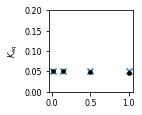

In [155]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.01
keq_sim = truth_df.loc[mask, "kon"] / truth_df.loc[mask, "koff"]
keq_fit = fit_df.loc[mask, "probs_z_1"] / fit_df.loc[mask, "probs_z_0"]
plt.scatter(truth_df.loc[mask, "rate_j"], keq_sim, marker="x")
plt.scatter(truth_df.loc[mask, "rate_j"], keq_fit, color="k", s=13)
plt.ylim(0, 0.2)
#plt.xlim(0, 0.2)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
# plt.xlabel(r"$\lambda$", fontsize=8)
plt.ylabel(r"$K_{eq}$", fontsize=8)
plt.savefig("/tmp/keq1.svg")
plt.show()

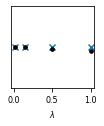

In [156]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.02
keq_sim = truth_df.loc[mask, "kon"] / truth_df.loc[mask, "koff"]
keq_fit = fit_df.loc[mask, "probs_z_1"] / fit_df.loc[mask, "probs_z_0"]
plt.scatter(truth_df.loc[mask, "rate_j"], keq_sim, marker="x")
plt.scatter(truth_df.loc[mask, "rate_j"], keq_fit, color="k", s=13)
plt.ylim(0, 0.2)
#plt.xlim(0, 0.2)
plt.yticks([], fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda$", fontsize=8)
# plt.ylabel(r"$K_{eq}$", fontsize=8)
plt.savefig("/tmp/keq2.svg")
plt.show()

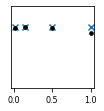

In [157]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.03
keq_sim = truth_df.loc[mask, "kon"] / truth_df.loc[mask, "koff"]
keq_fit = fit_df.loc[mask, "probs_z_1"] / fit_df.loc[mask, "probs_z_0"]
plt.scatter(truth_df.loc[mask, "rate_j"], keq_sim, marker="x")
plt.scatter(truth_df.loc[mask, "rate_j"], keq_fit, color="k", s=13)
plt.ylim(0, 0.2)
#plt.xlim(0, 0.2)
plt.yticks([], fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
# plt.xlabel(r"$\lambda$", fontsize=8)
# plt.ylabel(r"$K_{eq}$", fontsize=8)
plt.savefig("/tmp/keq3.svg")
plt.show()

#### Time-to-first binding

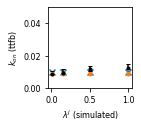

In [20]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.01
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "kon"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "kon_true"],
             yerr=abs(fit_df.loc[mask, ["kon_true_low", "kon_true_high"]].values.T-fit_df.loc[mask, "kon_true"].values),
             fmt="o", ms=3, mfc="C1", mec="C1", ecolor="C1", capsize=2)
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "kon_ttfb"],
             yerr=abs(fit_df.loc[mask, ["kon_ttfb_low", "kon_ttfb_high"]].values.T-fit_df.loc[mask, "kon_ttfb"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.05)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{on}$ (ttfb)", fontsize=8)
plt.savefig("/tmp/kon1-ttfb.svg")
plt.show()

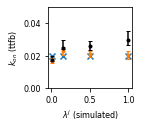

In [21]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.02
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "kon"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "kon_true"],
             yerr=abs(fit_df.loc[mask, ["kon_true_low", "kon_true_high"]].values.T-fit_df.loc[mask, "kon_true"].values),
             fmt="o", ms=3, mfc="C1", mec="C1", ecolor="C1", capsize=2)
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "kon_ttfb"],
             yerr=abs(fit_df.loc[mask, ["kon_ttfb_low", "kon_ttfb_high"]].values.T-fit_df.loc[mask, "kon_ttfb"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.05)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{on}$ (ttfb)", fontsize=8)
plt.savefig("/tmp/kon2-ttfb.svg")
plt.show()

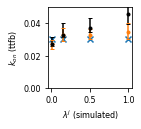

In [22]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.03
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "kon"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "kon_true"],
             yerr=abs(fit_df.loc[mask, ["kon_true_low", "kon_true_high"]].values.T-fit_df.loc[mask, "kon_true"].values),
             fmt="o", ms=3, mfc="C1", mec="C1", ecolor="C1", capsize=2)
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "kon_ttfb"],
             yerr=abs(fit_df.loc[mask, ["kon_ttfb_low", "kon_ttfb_high"]].values.T-fit_df.loc[mask, "kon_ttfb"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.05)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{on}$ (ttfb)", fontsize=8)
plt.savefig("/tmp/kon3-ttfb.svg")
plt.show()

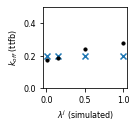

In [29]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.01
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "koff"], marker="x")
plt.scatter(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "koff_ttfb"], marker="o", s=10, color="k")
plt.ylim(0, 0.5)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{off}$ (ttfb)", fontsize=8)
plt.savefig("/tmp/koff1-ttfb.svg")
plt.show()

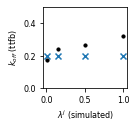

In [30]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.02
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "koff"], marker="x")
plt.scatter(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "koff_ttfb"], marker="o", s=10, color="k")
plt.ylim(0, 0.5)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{off}$ (ttfb)", fontsize=8)
plt.savefig("/tmp/koff2-ttfb.svg")
plt.show()

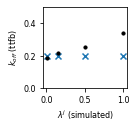

In [31]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.03
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "koff"], marker="x")
plt.scatter(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "koff_ttfb"], marker="o", s=10, color="k")
plt.ylim(0, 0.5)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{off}$ (ttfb)", fontsize=8)
plt.savefig("/tmp/koff3-ttfb.svg")
plt.show()

#### Dwell time

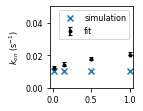

In [147]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.01
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "kon"], marker="x", label="simulation")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "kon"],
             yerr=abs(fit_df.loc[mask, ["kon_low", "kon_high"]].values.T-fit_df.loc[mask, "kon"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2, label="fit")
plt.ylim(0, 0.05)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
# plt.xlabel(r"$\lambda$", fontsize=8)
plt.ylabel(r"$k_{on}$ (s$^{-1}$)", fontsize=8)
plt.legend(fontsize=8)
plt.savefig("/tmp/kon1-dt.svg")
plt.show()

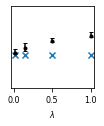

In [150]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.02
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "kon"], marker="x", label="simulation")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "kon"],
             yerr=abs(fit_df.loc[mask, ["kon_low", "kon_high"]].values.T-fit_df.loc[mask, "kon"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2, label="fit")
plt.ylim(0, 0.05)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks([], fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda$", fontsize=8)
# plt.ylabel(r"$k_{on}$ (s$^{-1}$)", fontsize=8)
# plt.legend(fontsize=8)
plt.savefig("/tmp/kon2-dt.svg")
plt.show()

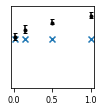

In [151]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.03
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "kon"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "kon"],
             yerr=abs(fit_df.loc[mask, ["kon_low", "kon_high"]].values.T-fit_df.loc[mask, "kon"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.05)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks([], fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
# plt.xlabel(r"$\lambda$", fontsize=8)
# plt.ylabel(r"$k_{on}$ (s$^{-1}$)", fontsize=8)
plt.savefig("/tmp/kon3-dt.svg")
plt.show()

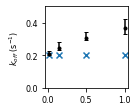

In [152]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.01
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "koff"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "koff"],
             yerr=abs(fit_df.loc[mask, ["koff_low", "koff_high"]].values.T-fit_df.loc[mask, "koff"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.5)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
# plt.xlabel(r"$\lambda$", fontsize=8)
plt.ylabel(r"$k_{off}$ (s$^{-1}$)", fontsize=8)
plt.savefig("/tmp/koff1-dt.svg")
plt.show()

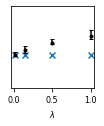

In [153]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.02
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "koff"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "koff"],
             yerr=abs(fit_df.loc[mask, ["koff_low", "koff_high"]].values.T-fit_df.loc[mask, "koff"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.5)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks([], fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda$", fontsize=8)
# plt.ylabel(r"$k_{off}$ (s$^{-1}$)", fontsize=8)
plt.savefig("/tmp/koff2-dt.svg")
plt.show()

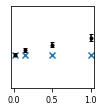

In [154]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.03
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "koff"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "koff"],
             yerr=abs(fit_df.loc[mask, ["koff_low", "koff_high"]].values.T-fit_df.loc[mask, "koff"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.5)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks([], fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
# plt.xlabel(r"$\lambda$", fontsize=8)
# plt.ylabel(r"$k_{off}$ (s$^{-1}$)", fontsize=8)
plt.savefig("/tmp/koff3-dt.svg")
plt.show()

#### Transition rates

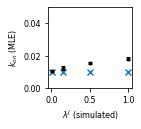

In [69]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.01
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "kon"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "A01"],
             yerr=abs(fit_df.loc[mask, ["A01_low", "A01_high"]].values.T-fit_df.loc[mask, "A01"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.05)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{on}$ (MLE)", fontsize=8)
plt.savefig("/tmp/a01-1.svg")
plt.show()

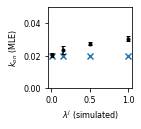

In [72]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.02
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "kon"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "A01"],
             yerr=abs(fit_df.loc[mask, ["A01_low", "A01_high"]].values.T-fit_df.loc[mask, "A01"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.05)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{on}$ (MLE)", fontsize=8)
plt.savefig("/tmp/a01-2.svg")
plt.show()

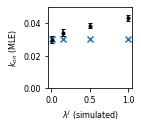

In [71]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.03
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "kon"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "A01"],
             yerr=abs(fit_df.loc[mask, ["A01_low", "A01_high"]].values.T-fit_df.loc[mask, "A01"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.05)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{on}$ (MLE)", fontsize=8)
plt.savefig("/tmp/a01-3.svg")
plt.show()

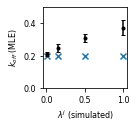

In [73]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.01
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "koff"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "A10"],
             yerr=abs(fit_df.loc[mask, ["A10_low", "A10_high"]].values.T-fit_df.loc[mask, "A10"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.5)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{off}$ (MLE)", fontsize=8)
plt.savefig("/tmp/a10-1.svg")
plt.show()

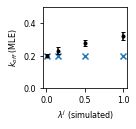

In [74]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.02
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "koff"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "A10"],
             yerr=abs(fit_df.loc[mask, ["A10_low", "A10_high"]].values.T-fit_df.loc[mask, "A10"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.5)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{off}$ (MLE)", fontsize=8)
plt.savefig("/tmp/a10-2.svg")
plt.show()

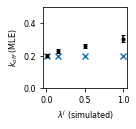

In [75]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.03
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "koff"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "A10"],
             yerr=abs(fit_df.loc[mask, ["A10_low", "A10_high"]].values.T-fit_df.loc[mask, "A10"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.5)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda^{j}$ (simulated)", fontsize=8)
plt.ylabel(r"$k_{off}$ (MLE)", fontsize=8)
plt.savefig("/tmp/a10-3.svg")
plt.show()

#### Double exponential

kon 0.01 ratej 0.01

In [78]:
data_path = EXAMLES_DIR / "kon1.00e-02ratej1.00e-02"
param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs64/"

model = Cosmos()
model.load(data_path, True, "cpu")
model.load_parameters(param_path)

dt = unbound_dwell_times(count_intervals(model.z_map))
dt = torch.tensor(dt, dtype=torch.float)

train(
    double_exp_model, double_exp_guide, lr=5e-3, n_steps=5000,
    data=dt
)

('k1: 0.06350056827068329', 'k2: 0.6058685779571533', 'A: 0.38364991545677185')
('k1: 0.044768959283828735', 'k2: 0.36226046085357666', 'A: 0.29461467266082764')
('k1: 0.03401659429073334', 'k2: 0.21377049386501312', 'A: 0.23201365768909454')
('k1: 0.027297621592879295', 'k2: 0.1263614296913147', 'A: 0.18972280621528625')
('k1: 0.022846411913633347', 'k2: 0.07481402903795242', 'A: 0.16182632744312286')
('k1: 0.019787734374403954', 'k2: 0.04273267090320587', 'A: 0.144346684217453')
('k1: 0.017681432887911797', 'k2: 0.0224155243486166', 'A: 0.13551877439022064')
('k1: 0.01643361896276474', 'k2: 0.010343590751290321', 'A: 0.13592246174812317')
('k1: 0.015844177454710007', 'k2: 0.007310196291655302', 'A: 0.14075829088687897')
('k1: 0.015413573011755943', 'k2: 0.0070169116370379925', 'A: 0.14420872926712036')
('k1: 0.015042401850223541', 'k2: 0.0071464283391833305', 'A: 0.1468653827905655')
('k1: 0.014714488759636879', 'k2: 0.007349228952080011', 'A: 0.1490650326013565')
('k1: 0.01442428492

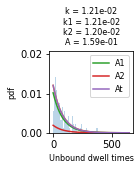

In [79]:
k = 1 / dt.mean()

plt.figure(figsize=(1.5, 1.5))
plt.title(
    f"k = {k:.2e}\nk1 = {pyro.param('k1').item():.2e}\nk2 = {pyro.param('k2').item():.2e}\nA = {pyro.param('A').item():.2e}",
    fontsize=8
)
plt.hist(dt.numpy(), bins=np.arange(0.5, dt.max(), 1), density=True, alpha=0.3)
x = torch.arange(0.01, dt.max())
d = dist.Exponential(k)
plt.plot(x, d.log_prob(x).exp())
d1 = (1 - pyro.param("A").item())*(dist.Exponential(pyro.param("k1").item()).log_prob(x)).exp()
d2 = pyro.param("A").item()*(dist.Exponential(pyro.param("k2").item()).log_prob(x)).exp()
plt.plot(x, d1, label="A1")
plt.plot(x, d2, label="A2")
plt.plot(x, d1+d2, label="At")
plt.xlabel("Unbound dwell times", fontsize=8)
plt.ylabel("pdf", fontsize=8)
#plt.ylim(0, 0.2)
#plt.xlim(0, 100)
plt.legend(fontsize=8)
plt.savefig("/tmp/kon1-ratej0.01.svg")
plt.show()

In [80]:
data_path = EXAMLES_DIR / "kon1.00e-02ratej1.00e-02"
param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs64/"

model = Cosmos()
model.load(data_path, True, "cpu")
model.load_parameters(param_path)

dt = bound_dwell_times(count_intervals(model.z_map))
dt = torch.tensor(dt, dtype=torch.float)

train(
    double_exp_model, double_exp_guide, lr=5e-3, n_steps=5000,
    data=dt
)

('k1: 0.14971280097961426', 'k2: 0.6484504342079163', 'A: 0.3935500681400299')
('k1: 0.17172476649284363', 'k2: 0.48611536622047424', 'A: 0.3294101357460022')
('k1: 0.18012689054012299', 'k2: 0.3981591761112213', 'A: 0.29497718811035156')
('k1: 0.18594607710838318', 'k2: 0.3445281386375427', 'A: 0.2760971486568451')
('k1: 0.19041860103607178', 'k2: 0.30887651443481445', 'A: 0.2650696039199829')
('k1: 0.1940411925315857', 'k2: 0.2836964726448059', 'A: 0.2583502531051636')
('k1: 0.19706597924232483', 'k2: 0.26515236496925354', 'A: 0.25416290760040283')
('k1: 0.1996253877878189', 'k2: 0.25112155079841614', 'A: 0.2515399158000946')
('k1: 0.20179034769535065', 'k2: 0.24035032093524933', 'A: 0.24991253018379211')
('k1: 0.20360161364078522', 'k2: 0.2320493906736374', 'A: 0.2489253729581833')
('k1: 0.2050875872373581', 'k2: 0.22568492591381073', 'A: 0.24834613502025604')
('k1: 0.20627547800540924', 'k2: 0.2208659052848816', 'A: 0.24802041053771973')
('k1: 0.207196906208992', 'k2: 0.21728293597

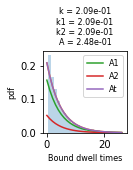

In [81]:
k = 1 / dt.mean()

plt.figure(figsize=(1.5, 1.5))
plt.title(
    f"k = {k:.2e}\nk1 = {pyro.param('k1').item():.2e}\nk2 = {pyro.param('k2').item():.2e}\nA = {pyro.param('A').item():.2e}",
    fontsize=8
)
plt.hist(dt.numpy(), bins=np.arange(0.5, dt.max(), 1), density=True, alpha=0.3)
x = torch.arange(0.01, dt.max())
d = dist.Exponential(k)
plt.plot(x, d.log_prob(x).exp())
d1 = (1 - pyro.param("A").item())*(dist.Exponential(pyro.param("k1").item()).log_prob(x)).exp()
d2 = pyro.param("A").item()*(dist.Exponential(pyro.param("k2").item()).log_prob(x)).exp()
plt.plot(x, d1, label="A1")
plt.plot(x, d2, label="A2")
plt.plot(x, d1+d2, label="At")
plt.xlabel("Bound dwell times", fontsize=8)
plt.ylabel("pdf", fontsize=8)
#plt.ylim(0, 0.2)
#plt.xlim(0, 100)
plt.legend(fontsize=8)
plt.savefig("/tmp/koff1-ratej0.01.svg")
plt.show()

kon 0.01 ratej 1.00

In [66]:
data_path = EXAMLES_DIR / "kon1.00e-02ratej1.00e+00"
param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs64/"

model = Cosmos()
model.load(data_path, True, "cpu")
model.load_parameters(param_path)

dt = unbound_dwell_times(count_intervals(model.z_map))
dt = torch.tensor(dt, dtype=torch.float)

train(
    double_exp_model, double_exp_guide, lr=5e-3, n_steps=5000,
    data=dt
)

('k1: 0.06370566040277481', 'k2: 0.7373402714729309', 'A: 0.38657346367836')
('k1: 0.04545006528496742', 'k2: 0.7430614829063416', 'A: 0.3059215247631073')
('k1: 0.03520922362804413', 'k2: 0.7553278803825378', 'A: 0.25346001982688904')
('k1: 0.028972897678613663', 'k2: 0.7594814300537109', 'A: 0.22111192345619202')
('k1: 0.024956608191132545', 'k2: 0.7591165900230408', 'A: 0.20220865309238434')
('k1: 0.022269753739237785', 'k2: 0.7558366060256958', 'A: 0.19215133786201477')
('k1: 0.020426707342267036', 'k2: 0.7507323622703552', 'A: 0.18782560527324677')
('k1: 0.01914343424141407', 'k2: 0.7447078824043274', 'A: 0.18703804910182953')
('k1: 0.018243955448269844', 'k2: 0.7385425567626953', 'A: 0.18820004165172577')
('k1: 0.017613809555768967', 'k2: 0.7328503131866455', 'A: 0.19019094109535217')
('k1: 0.01717550680041313', 'k2: 0.7280252575874329', 'A: 0.1922929435968399')
('k1: 0.01687457412481308', 'k2: 0.7242273688316345', 'A: 0.19412262737751007')
('k1: 0.016671737655997276', 'k2: 0.721

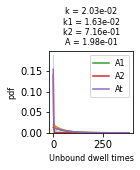

In [67]:
k = 1 / dt.mean()

plt.figure(figsize=(1.5, 1.5))
plt.title(
    f"k = {k:.2e}\nk1 = {pyro.param('k1').item():.2e}\nk2 = {pyro.param('k2').item():.2e}\nA = {pyro.param('A').item():.2e}",
    fontsize=8
)
plt.hist(dt.numpy(), bins=np.arange(0.5, dt.max(), 1), density=True, alpha=0.3)
x = torch.arange(0.01, dt.max())
d = dist.Exponential(k)
plt.plot(x, d.log_prob(x).exp())
d1 = (1 - pyro.param("A").item())*(dist.Exponential(pyro.param("k1").item()).log_prob(x)).exp()
d2 = pyro.param("A").item()*(dist.Exponential(pyro.param("k2").item()).log_prob(x)).exp()
plt.plot(x, d1, label="A1")
plt.plot(x, d2, label="A2")
plt.plot(x, d1+d2, label="At")
plt.xlabel("Unbound dwell times", fontsize=8)
plt.ylabel("pdf", fontsize=8)
#plt.ylim(0, 0.2)
#plt.xlim(0, 100)
plt.legend(fontsize=8)
plt.savefig("/tmp/kon1-ratej1.00.svg")
plt.show()

In [4]:
data_path = EXAMLES_DIR / "kon1.00e-02ratej1.00e+00"
param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs64/"

model = Cosmos()
model.load(data_path, True, "cpu")
model.load_parameters(param_path)

dt = bound_dwell_times(count_intervals(model.z_map))
dt = torch.tensor(dt, dtype=torch.float)

train(
    double_exp_model, double_exp_guide, lr=5e-3, n_steps=15000,
    data=dt
)

('k1: 0.01582295261323452', 'k2: 0.6447557806968689', 'A: 0.6191235184669495')
('k1: 0.02296561375260353', 'k2: 0.49862685799598694', 'A: 0.7133064866065979')
('k1: 0.032011259347200394', 'k2: 0.4466816782951355', 'A: 0.7790663838386536')
('k1: 0.04393983632326126', 'k2: 0.4308100640773773', 'A: 0.8228291869163513')
('k1: 0.059686437249183655', 'k2: 0.4259989559650421', 'A: 0.8515464663505554')
('k1: 0.07969986647367477', 'k2: 0.42355167865753174', 'A: 0.8702085018157959')
('k1: 0.10330363363027573', 'k2: 0.42083939909935', 'A: 0.8821159601211548')
('k1: 0.12837651371955872', 'k2: 0.4171341061592102', 'A: 0.8895293474197388')
('k1: 0.1521536111831665', 'k2: 0.4126369059085846', 'A: 0.8940733075141907')
('k1: 0.1726839244365692', 'k2: 0.4080198407173157', 'A: 0.8968862891197205')
('k1: 0.18942977488040924', 'k2: 0.4038616418838501', 'A: 0.8986960053443909')
('k1: 0.20278234779834747', 'k2: 0.40039217472076416', 'A: 0.8999266028404236')
('k1: 0.21341916918754578', 'k2: 0.3975909352302551

('k1: 0.1826348751783371', 'k2: 0.3786795139312744', 'A: 0.9755368232727051')
('k1: 0.18135593831539154', 'k2: 0.3785310983657837', 'A: 0.976219892501831')
('k1: 0.1801624894142151', 'k2: 0.3783912658691406', 'A: 0.9768489003181458')
('k1: 0.1790531873703003', 'k2: 0.37826016545295715', 'A: 0.9774261116981506')
('k1: 0.1780262142419815', 'k2: 0.3781377971172333', 'A: 0.9779542684555054')
('k1: 0.17707958817481995', 'k2: 0.3780241906642914', 'A: 0.978435754776001')
('k1: 0.17621074616909027', 'k2: 0.37791934609413147', 'A: 0.9788731336593628')
('k1: 0.17541690170764923', 'k2: 0.3778229057788849', 'A: 0.9792690873146057')
('k1: 0.17469508945941925', 'k2: 0.3777347505092621', 'A: 0.9796261191368103')
('k1: 0.1740420162677765', 'k2: 0.3776545822620392', 'A: 0.9799464344978333')
('k1: 0.1734543740749359', 'k2: 0.3775821626186371', 'A: 0.980232834815979')
('k1: 0.1729285717010498', 'k2: 0.3775171935558319', 'A: 0.9804872870445251')
('k1: 0.17246094346046448', 'k2: 0.3774590492248535', 'A: 0.

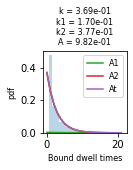

In [5]:
k = 1 / dt.mean()

plt.figure(figsize=(1.5, 1.5))
plt.title(
    f"k = {k:.2e}\nk1 = {pyro.param('k1').item():.2e}\nk2 = {pyro.param('k2').item():.2e}\nA = {pyro.param('A').item():.2e}",
    fontsize=8
)
plt.hist(dt.numpy(), bins=np.arange(0.5, dt.max(), 1), density=True, alpha=0.3)
x = torch.arange(0.01, dt.max())
d = dist.Exponential(k)
plt.plot(x, d.log_prob(x).exp())
d1 = (1 - pyro.param("A").item())*(dist.Exponential(pyro.param("k1").item()).log_prob(x)).exp()
d2 = pyro.param("A").item()*(dist.Exponential(pyro.param("k2").item()).log_prob(x)).exp()
plt.plot(x, d1, label="A1")
plt.plot(x, d2, label="A2")
plt.plot(x, d1+d2, label="At")
plt.xlabel("Bound dwell times", fontsize=8)
plt.ylabel("pdf", fontsize=8)
#plt.ylim(0, 0.2)
#plt.xlim(0, 100)
plt.legend(fontsize=8)
plt.savefig("/tmp/koff1-ratej1.00.svg")
plt.show()

kon 0.03 ratej 0.01

In [70]:
data_path = EXAMLES_DIR / "kon3.00e-02ratej1.00e-02"
param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs64/"

model = Cosmos()
model.load(data_path, True, "cpu")
model.load_parameters(param_path)

dt = unbound_dwell_times(count_intervals(model.z_map))
dt = torch.tensor(dt, dtype=torch.float)

train(
    double_exp_model, double_exp_guide, lr=5e-3, n_steps=5000,
    data=dt
)

('k1: 0.06429889053106308', 'k2: 0.6089930534362793', 'A: 0.3852241039276123')
('k1: 0.04733523353934288', 'k2: 0.38338184356689453', 'A: 0.3016999065876007')
('k1: 0.03843194246292114', 'k2: 0.2551793158054352', 'A: 0.2464461773633957')
('k1: 0.033476945012807846', 'k2: 0.17957662045955658', 'A: 0.2113204300403595')
('k1: 0.030689915642142296', 'k2: 0.13262619078159332', 'A: 0.18942521512508392')
('k1: 0.029186978936195374', 'k2: 0.10220082104206085', 'A: 0.17602312564849854')
('k1: 0.028475327417254448', 'k2: 0.08191794157028198', 'A: 0.16801241040229797')
('k1: 0.02825082093477249', 'k2: 0.06815483421087265', 'A: 0.1633557826280594')
('k1: 0.028311533853411674', 'k2: 0.05868731439113617', 'A: 0.16071423888206482')
('k1: 0.028520368039608', 'k2: 0.052068036049604416', 'A: 0.159232035279274')
('k1: 0.028788505122065544', 'k2: 0.0473371297121048', 'A: 0.15839232504367828')
('k1: 0.029064159840345383', 'k2: 0.04386519268155098', 'A: 0.15790243446826935')
('k1: 0.029321780428290367', 'k2

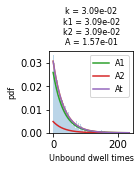

In [71]:
k = 1 / dt.mean()

plt.figure(figsize=(1.5, 1.5))
plt.title(
    f"k = {k:.2e}\nk1 = {pyro.param('k1').item():.2e}\nk2 = {pyro.param('k2').item():.2e}\nA = {pyro.param('A').item():.2e}",
    fontsize=8
)
plt.hist(dt.numpy(), bins=np.arange(0.5, dt.max(), 1), density=True, alpha=0.3)
x = torch.arange(0.01, dt.max())
d = dist.Exponential(k)
plt.plot(x, d.log_prob(x).exp())
d1 = (1 - pyro.param("A").item())*(dist.Exponential(pyro.param("k1").item()).log_prob(x)).exp()
d2 = pyro.param("A").item()*(dist.Exponential(pyro.param("k2").item()).log_prob(x)).exp()
plt.plot(x, d1, label="A1")
plt.plot(x, d2, label="A2")
plt.plot(x, d1+d2, label="At")
plt.xlabel("Unbound dwell times", fontsize=8)
plt.ylabel("pdf", fontsize=8)
#plt.ylim(0, 0.2)
#plt.xlim(0, 100)
plt.legend(fontsize=8)
plt.savefig("/tmp/kon3-ratej0.01.svg")
plt.show()

In [72]:
data_path = EXAMLES_DIR / "kon3.00e-02ratej1.00e-02"
param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs64/"

model = Cosmos()
model.load(data_path, True, "cpu")
model.load_parameters(param_path)

dt = bound_dwell_times(count_intervals(model.z_map))
dt = torch.tensor(dt, dtype=torch.float)

train(
    double_exp_model, double_exp_guide, lr=5e-3, n_steps=5000,
    data=dt
)

('k1: 0.14859764277935028', 'k2: 0.6439282298088074', 'A: 0.39227402210235596')
('k1: 0.1681232452392578', 'k2: 0.4729207754135132', 'A: 0.3269785940647125')
('k1: 0.17614763975143433', 'k2: 0.37837734818458557', 'A: 0.29228711128234863')
('k1: 0.18218424916267395', 'k2: 0.3205605149269104', 'A: 0.27381956577301025')
('k1: 0.18697665631771088', 'k2: 0.28268298506736755', 'A: 0.2637477517127991')
('k1: 0.19085614383220673', 'k2: 0.25684916973114014', 'A: 0.2582547664642334')
('k1: 0.1939850002527237', 'k2: 0.23888356983661652', 'A: 0.2553217113018036')
('k1: 0.19645150005817413', 'k2: 0.2263450026512146', 'A: 0.25381582975387573')
('k1: 0.19832558929920197', 'k2: 0.21767687797546387', 'A: 0.2530836760997772')
('k1: 0.199686199426651', 'k2: 0.21180503070354462', 'A: 0.25275105237960815')
('k1: 0.20062582194805145', 'k2: 0.207940936088562', 'A: 0.252610981464386')
('k1: 0.2012421041727066', 'k2: 0.20548605918884277', 'A: 0.2525566816329956')
('k1: 0.20162619650363922', 'k2: 0.203987047076

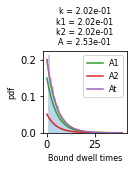

In [73]:
k = 1 / dt.mean()

plt.figure(figsize=(1.5, 1.5))
plt.title(
    f"k = {k:.2e}\nk1 = {pyro.param('k1').item():.2e}\nk2 = {pyro.param('k2').item():.2e}\nA = {pyro.param('A').item():.2e}",
    fontsize=8
)
plt.hist(dt.numpy(), bins=np.arange(0.5, dt.max(), 1), density=True, alpha=0.3)
x = torch.arange(0.01, dt.max())
d = dist.Exponential(k)
plt.plot(x, d.log_prob(x).exp())
d1 = (1 - pyro.param("A").item())*(dist.Exponential(pyro.param("k1").item()).log_prob(x)).exp()
d2 = pyro.param("A").item()*(dist.Exponential(pyro.param("k2").item()).log_prob(x)).exp()
plt.plot(x, d1, label="A1")
plt.plot(x, d2, label="A2")
plt.plot(x, d1+d2, label="At")
plt.xlabel("Bound dwell times", fontsize=8)
plt.ylabel("pdf", fontsize=8)
#plt.ylim(0, 0.2)
#plt.xlim(0, 100)
plt.legend(fontsize=8)
plt.savefig("/tmp/koff3-ratej0.01.svg")
plt.show()

kon 0.03 ratej 1.00

In [74]:
data_path = EXAMLES_DIR / "kon3.00e-02ratej1.00e+00"
param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs64/"

model = Cosmos()
model.load(data_path, True, "cpu")
model.load_parameters(param_path)

dt = unbound_dwell_times(count_intervals(model.z_map))
dt = torch.tensor(dt, dtype=torch.float)

train(
    double_exp_model, double_exp_guide, lr=5e-3, n_steps=5000,
    data=dt
)

('k1: 0.06476425379514694', 'k2: 0.6542090177536011', 'A: 0.3885544538497925')
('k1: 0.048972658812999725', 'k2: 0.5223057270050049', 'A: 0.31467205286026')
('k1: 0.041448865085840225', 'k2: 0.4862697720527649', 'A: 0.2697051763534546')
('k1: 0.03786434605717659', 'k2: 0.49229317903518677', 'A: 0.2423112690448761')
('k1: 0.03629130497574806', 'k2: 0.5118237733840942', 'A: 0.22487778961658478')
('k1: 0.03573278337717056', 'k2: 0.5313205122947693', 'A: 0.21313484013080597')
('k1: 0.0356387235224247', 'k2: 0.5468981266021729', 'A: 0.20483404397964478')
('k1: 0.035717885941267014', 'k2: 0.5585981607437134', 'A: 0.19879093766212463')
('k1: 0.03583487123250961', 'k2: 0.5672031044960022', 'A: 0.19435308873653412')
('k1: 0.035939160734415054', 'k2: 0.5734153389930725', 'A: 0.1911219358444214')
('k1: 0.03601841256022453', 'k2: 0.5777995586395264', 'A: 0.18881642818450928')
('k1: 0.03607432544231415', 'k2: 0.5808144211769104', 'A: 0.1872156709432602')
('k1: 0.036111991852521896', 'k2: 0.58282828

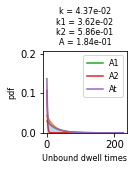

In [75]:
k = 1 / dt.mean()

plt.figure(figsize=(1.5, 1.5))
plt.title(
    f"k = {k:.2e}\nk1 = {pyro.param('k1').item():.2e}\nk2 = {pyro.param('k2').item():.2e}\nA = {pyro.param('A').item():.2e}",
    fontsize=8
)
plt.hist(dt.numpy(), bins=np.arange(0.5, dt.max(), 1), density=True, alpha=0.3)
x = torch.arange(0.01, dt.max())
d = dist.Exponential(k)
plt.plot(x, d.log_prob(x).exp())
d1 = (1 - pyro.param("A").item())*(dist.Exponential(pyro.param("k1").item()).log_prob(x)).exp()
d2 = pyro.param("A").item()*(dist.Exponential(pyro.param("k2").item()).log_prob(x)).exp()
plt.plot(x, d1, label="A1")
plt.plot(x, d2, label="A2")
plt.plot(x, d1+d2, label="At")
plt.xlabel("Unbound dwell times", fontsize=8)
plt.ylabel("pdf", fontsize=8)
#plt.ylim(0, 0.2)
#plt.xlim(0, 100)
plt.legend(fontsize=8)
plt.savefig("/tmp/kon3-ratej1.00.svg")
plt.show()

In [76]:
data_path = EXAMLES_DIR / "kon3.00e-02ratej1.00e+00"
param_path = data_path / "runs/cosmos/v1.1.6/S1/control/lr0.005/bs64/"

model = Cosmos()
model.load(data_path, True, "cpu")
model.load_parameters(param_path)

dt = bound_dwell_times(count_intervals(model.z_map))
dt = torch.tensor(dt, dtype=torch.float)

train(
    double_exp_model, double_exp_guide, lr=5e-3, n_steps=5000,
    data=dt
)

('k1: 0.15617799758911133', 'k2: 0.647297203540802', 'A: 0.5069931149482727')
('k1: 0.20707674324512482', 'k2: 0.4913097620010376', 'A: 0.4942482113838196')
('k1: 0.24359451234340668', 'k2: 0.41981959342956543', 'A: 0.45229554176330566')
('k1: 0.2674409747123718', 'k2: 0.38248029351234436', 'A: 0.4005151093006134')
('k1: 0.282022088766098', 'k2: 0.3598668575286865', 'A: 0.35330092906951904')
('k1: 0.2904234230518341', 'k2: 0.3445858061313629', 'A: 0.3189501464366913')
('k1: 0.295314222574234', 'k2: 0.3336505889892578', 'A: 0.29734253883361816')
('k1: 0.2983766496181488', 'k2: 0.32561224699020386', 'A: 0.28469809889793396')
('k1: 0.3004414439201355', 'k2: 0.3196442425251007', 'A: 0.27759549021720886')
('k1: 0.301898717880249', 'k2: 0.3152262568473816', 'A: 0.27375516295433044')
('k1: 0.3029445707798004', 'k2: 0.3119976222515106', 'A: 0.27176886796951294')
('k1: 0.30369165539741516', 'k2: 0.30968523025512695', 'A: 0.2707931697368622')
('k1: 0.3042151629924774', 'k2: 0.3080712854862213', 

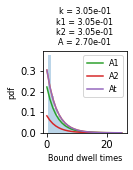

In [77]:
k = 1 / dt.mean()

plt.figure(figsize=(1.5, 1.5))
plt.title(
    f"k = {k:.2e}\nk1 = {pyro.param('k1').item():.2e}\nk2 = {pyro.param('k2').item():.2e}\nA = {pyro.param('A').item():.2e}",
    fontsize=8
)
plt.hist(dt.numpy(), bins=np.arange(0.5, dt.max(), 1), density=True, alpha=0.3)
x = torch.arange(0.01, dt.max())
d = dist.Exponential(k)
plt.plot(x, d.log_prob(x).exp())
d1 = (1 - pyro.param("A").item())*(dist.Exponential(pyro.param("k1").item()).log_prob(x)).exp()
d2 = pyro.param("A").item()*(dist.Exponential(pyro.param("k2").item()).log_prob(x)).exp()
plt.plot(x, d1, label="A1")
plt.plot(x, d2, label="A2")
plt.plot(x, d1+d2, label="At")
plt.xlabel("Bound dwell times", fontsize=8)
plt.ylabel("pdf", fontsize=8)
#plt.ylim(0, 0.2)
#plt.xlim(0, 100)
plt.legend(fontsize=8)
plt.savefig("/tmp/koff3-ratej1.00.svg")
plt.show()

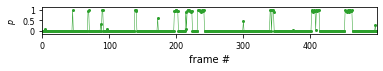

In [96]:
plt.figure(figsize=(6, 0.5))

f1 = 0
f2 = 500
plt.plot(
    model.data.drift.index[f1:f2],
    model.z_marginal[0, f1:f2],
    "o-", ms=2, lw=0.5, color="C2", label="fit")

plt.xticks(fontsize=8)
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-1, f2-1)
plt.ylim(-0.15, 1.15)
plt.ylabel(r"$p$", fontsize=8)
plt.xlabel("frame #")
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
# plt.legend(fontsize=8)

plt.savefig("/tmp/kinetic-trace.svg")
plt.show()

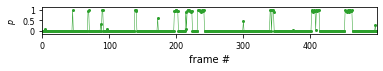

In [47]:
plt.figure(figsize=(6, 0.5))

f1 = 0
f2 = 500
plt.plot(
    model.data.drift.index[f1:f2],
    model.z_marginal[0, f1:f2],
    "o-", ms=2, lw=0.5, color="C2", label="fit")

plt.xticks(fontsize=8)
plt.yticks([0, 0.5, 1], fontsize=8)
plt.xlim(f1-1, f2-1)
plt.ylim(-0.15, 1.15)
plt.ylabel(r"$p$", fontsize=8)
plt.xlabel("frame #")
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
# plt.legend(fontsize=8)

plt.savefig("/tmp/kinetic-trace.svg")
plt.show()

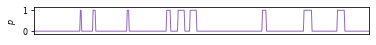

In [50]:
plt.figure(figsize=(6, 0.5))

f1 = 0
f2 = 500
plt.plot(
    model.data.drift.index[f1:f2],
    model.data.labels["z"][0, f1:f2],
    "-", lw=1, color="C4", label="simulation")

plt.xticks([], fontsize=8)
plt.yticks([0, 1], fontsize=8)
plt.xlim(f1-1, f2-1)
plt.ylim(-0.15, 1.15)
plt.ylabel(r"$p$", fontsize=8)
# plt.xlabel("frame #")
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
# plt.legend(fontsize=8)

plt.savefig("/tmp/kinetic-sim.svg")
plt.show()

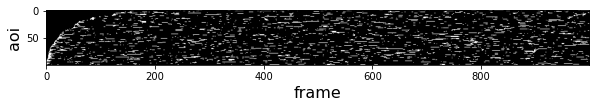

In [12]:
frames = np.arange(1, model.data.F+1)
q1 = np.ones((model.data.N, model.data.F))
q1[:, :-1] = model.data.labels["z"][:, 1:]
cumq0 = np.cumprod(1 - model.data.labels["z"], axis=-1)
sttfb = (frames * q1 * cumq0).sum(-1)

sdx = np.flip(np.argsort(sttfb))

figsize = torch.tensor([10, 10 * model.data.N / model.data.F])
plt.figure(figsize=figsize)

plt.imshow(model.data.labels["z"][sdx], cmap="gray")
plt.xlabel("frame", fontsize=16)
plt.ylabel("aoi", fontsize=16)
plt.show()

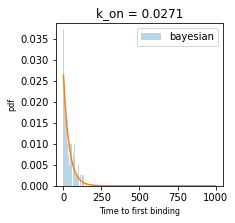

In [87]:
frames = torch.arange(1, model.data.F+1)
q1 = torch.ones(model.data.N, model.data.F)
q1[:, :-1] = model.z_marginal[:, 1:]
cumq0 = torch.cumprod(1 - model.z_marginal, dim=-1)
ttfb = (frames * q1 * cumq0).sum(-1) #/ (1 - model.z_marginal[:, 0])
ttfb = ttfb - 1
mask = ttfb > 0
ttfb = ttfb[mask]

kon = 1 / ttfb.mean()

plt.figure(figsize=(3, 3))
plt.title(f"k_on = {kon:.4f}")
plt.hist(ttfb.numpy(), bins=30, density=True, alpha=0.3, label="bayesian")
# plt.hist(sttfb, bins=20, density=True, alpha=0.3, label="spotpicker")
x = torch.arange(1,model.data.F)
d = dist.Exponential(kon)
plt.plot(x, d.log_prob(x).exp())
plt.xlabel("Time to first binding", fontsize=8)
plt.ylabel("pdf", fontsize=8)
# plt.xlim(0, 100)
plt.legend()
plt.show()

### Poster

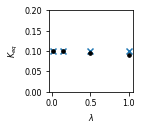

In [126]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.02
keq_sim = truth_df.loc[mask, "kon"] / truth_df.loc[mask, "koff"]
keq_fit = fit_df.loc[mask, "probs_z_1"] / fit_df.loc[mask, "probs_z_0"]
plt.scatter(truth_df.loc[mask, "rate_j"], keq_sim, marker="x")
plt.scatter(truth_df.loc[mask, "rate_j"], keq_fit, color="k", s=13)
plt.ylim(0, 0.2)
#plt.xlim(0, 0.2)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda$", fontsize=8)
plt.ylabel(r"$K_{eq}$", fontsize=8)
plt.savefig("/tmp/keq2.svg")
plt.show()

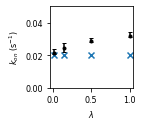

In [127]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.02
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "kon"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "kon"],
             yerr=abs(fit_df.loc[mask, ["kon_low", "kon_high"]].values.T-fit_df.loc[mask, "kon"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.05)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda$", fontsize=8)
plt.ylabel(r"$k_{on}$ (s$^{-1}$)", fontsize=8)
plt.savefig("/tmp/kon2-dt.svg")
plt.show()

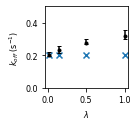

In [128]:
plt.figure(figsize=(1.5, 1.5))
mask = truth_df["kon"] == 0.02
plt.scatter(truth_df.loc[mask, "rate_j"], truth_df.loc[mask, "koff"], marker="x")
plt.errorbar(truth_df.loc[mask, "rate_j"], fit_df.loc[mask, "koff"],
             yerr=abs(fit_df.loc[mask, ["koff_low", "koff_high"]].values.T-fit_df.loc[mask, "koff"].values),
             fmt="o", ms=3, mfc="k", mec="k", ecolor="k", capsize=2)
plt.ylim(0, 0.5)
#plt.xlim(0, 0.3)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xticks([0, 0.5, 1], fontsize=8)
plt.xlabel(r"$\lambda$", fontsize=8)
plt.ylabel(r"$k_{off}$ (s$^{-1}$)", fontsize=8)
plt.savefig("/tmp/koff2-dt.svg")
plt.show()

### Analysis

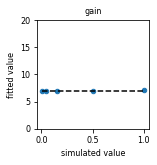

In [23]:
plt.figure(figsize=(2, 2))
plt.title("gain", fontsize=8)
plt.plot(truth_df["rate_j"].sort_values(), truth_df["gain"].sort_values(), "k--")
plt.scatter(truth_df["rate_j"], fit_df["gain"], s=20)
plt.ylim(0, 20)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("simulated value", fontsize=8)
plt.ylabel("fitted value", fontsize=8)
plt.show()

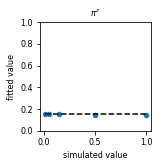

In [24]:
plt.figure(figsize=(2, 2))
plt.title(r"$\pi^z$", fontsize=8)
plt.plot(truth_df["rate_j"].sort_values(), truth_df["probs_z"].sort_values(), "k--")
plt.scatter(truth_df["rate_j"], fit_df["probs_z_1"], s=20)
plt.ylim(0, 1)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("simulated value", fontsize=8)
plt.ylabel("fitted value", fontsize=8)
plt.show()

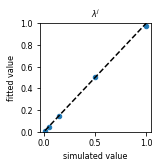

In [25]:
plt.figure(figsize=(2, 2))
plt.title(r"$\lambda^j$", fontsize=8)
plt.plot(truth_df["rate_j"].sort_values(), truth_df["rate_j"].sort_values(), "k--")
plt.scatter(truth_df["rate_j"], fit_df["rate_j"], s=20)
plt.ylim(0, 1.)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("simulated value", fontsize=8)
plt.ylabel("fitted value", fontsize=8)
plt.show()

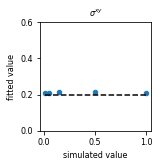

In [26]:
plt.figure(figsize=(2, 2))
plt.title(r"$\sigma^{xy}$", fontsize=8)
plt.plot(truth_df["rate_j"].sort_values(), truth_df["proximity"].sort_values(), "k--")
plt.scatter(truth_df["rate_j"], fit_df["proximity_0"], s=20)
plt.ylim(0., 0.6)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("simulated value", fontsize=8)
plt.ylabel("fitted value", fontsize=8)
plt.show()